In [2]:
import tensorflow as tf
import sympy as sm
import numpy as np
import keras
import matplotlib.pyplot as plt

In [6]:
with tf.GradientTape() as g:
  x = tf.constant([[1., 2.], [3., 4.]], dtype=tf.float32)
  g.watch(x)
  y = x * x
  print(y)
batch_jacobian = g.batch_jacobian(y, x)
print(batch_jacobian)
# batch_jacobian is [[[2,  0], [0,  4]], [[6,  0], [0,  8]]]


tf.Tensor(
[[ 1.  4.]
 [ 9. 16.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[[2. 0.]
  [0. 4.]]

 [[6. 0.]
  [0. 8.]]], shape=(2, 2, 2), dtype=float32)


In [9]:
output_dim = 2
dim = 1
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[dim]))
model.add(keras.layers.Dense(output_dim))
model.summary()

X = tf.random.uniform((5,dim),0,1,dtype=np.float32)

@tf.function
def differentiate(model, X, training=False):
    with tf.GradientTape() as tape:
        x1 = X[:, 0:1]
        tape.watch(x1)
        u = model(tf.stack([x1[:, 0]], axis=1), training=training)
    du_dx = tf.squeeze(tape.batch_jacobian(u, x1))
    del tape
    print('previous_shape:', du_dx.shape)
    du_dx = tf.reshape(du_dx, (X.shape[0],u.shape[-1]))
    return u, du_dx

[differentiate(model,X)[i].shape for i in range(2)]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
previous_shape: (5, 2)


[TensorShape([5, 2]), TensorShape([5, 2])]

In [17]:
output_dim = 2
dim = 2
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[dim]))
model.add(keras.layers.Dense(output_dim))
model.summary()

X = tf.random.uniform((5,dim),0,1,dtype=np.float32)
@tf.function
def differentiate(model, x, training=False):
    with tf.GradientTape(persistent=True) as tape:
        x1 = x[:, 0:1]
        tape.watch(x1)
        x2= x[:, 1:2]
        tape.watch(x2)
        # print(model(tf.stack([x1[:, 0],x2[:,0]], axis=1), training=training))
        u = model(tf.stack([x1[:, 0],x2[:,0]], axis=1), training=training)
        du_dx = tape.batch_jacobian(u, x1)
        du_dy = tape.batch_jacobian(u, x2)
    # print(u)
    # print(du_dx)
    du_dxx = tape.batch_jacobian(du_dx, x1)
    # print("du_dxx\n",du_dxx.shape)
    du_dyy = tape.batch_jacobian(du_dy, x2)
    del tape
    print(x.shape)

    du_dxx = tf.reshape(du_dxx,shape=[x.shape[0],u.shape[-1]])
    du_dyy = tf.reshape(du_dyy,shape=[x.shape[0],u.shape[-1]])
    du_dx = tf.reshape(du_dx,shape=[x.shape[0],u.shape[-1]])
    du_dy = tf.reshape(du_dy,shape=[x.shape[0],u.shape[-1]])
    return u, du_dx, du_dxx, du_dy, du_dyy

[differentiate(model,X)[i].shape for i in range(5)]

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 2)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
(5, 2)


[TensorShape([5, 2]),
 TensorShape([5, 2]),
 TensorShape([5, 2]),
 TensorShape([5, 2]),
 TensorShape([5, 2])]

In [38]:
output_dim = 2
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[1]))
model.add(keras.layers.Dense(output_dim))
model.summary()
dim = 2
X = tf.random.uniform((5,dim),0,1,dtype=np.float32)
with tf.GradientTape(persistent=True) as g:
    x1 = X[:,0:1]
    g.watch(x1)
    y = model(tf.stack([x1[:, 0]], axis=1))
    # print("y\n",y)
    y0 = y[:,0]
    if output_dim>=2:
        y1 = y[:,1]
der = g.gradient(y,x1)
der0 = g.gradient(y0,x1)
print("der0;\n",der0)
if output_dim>=2:
    der1 = g.gradient(y1,x1)
    print("der1\n",der1)
der_jac = tf.squeeze(g.batch_jacobian(y,x1))
if output_dim==1:
    der_jac = tf.expand_dims(der_jac,axis=-1)
del g
# print("der\n",der)

print("der_jac\n",der_jac)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 2)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
der0;
 tf.Tensor(
[[0.45608413]
 [0.45608413]
 [0.45608413]
 [0.45608413]
 [0.45608413]], shape=(5, 1), dtype=float32)
der1
 tf.Tensor(
[[0.143543]
 [0.143543]
 [0.143543]
 [0.143543]
 [0.143543]], shape=(5, 1), dtype=float32)
der_jac
 tf.Tensor(
[[0.45608413 0.143543  ]
 [0.45608413 0.143543  ]
 [0.45608413 0.143543  ]
 [0.45608413 0.143543  ]
 [0.45608413 0.143543  ]], shape=(5, 2), dtype=float32)


In [40]:
res = tf.random.uniform((5,2),0,1)

loss = tf.reduce_mean(tf.square(res))
print(loss)

metric = tf.keras.metrics.MeanSquaredError(name='mse',dtype=None)
print(metric(res))

tf.Tensor(0.2520027, shape=(), dtype=float32)


TypeError: update_state() missing 1 required positional argument: 'y_pred'

In [44]:
tf_sample_coords = tf.random.uniform((3, 2), [0,-10], [1,-1])
print(tf_sample_coords)

tf.Tensor(
[[ 0.60068214 -4.3473434 ]
 [ 0.20199859 -8.657986  ]
 [ 0.5060885  -9.515091  ]], shape=(3, 2), dtype=float32)


In [77]:
tf_sample_coords2 = tf.random.uniform((3, 2), [0,-10], [1,-9])
print(tf_sample_coords2)

tf.Tensor(
[[ 0.18454349 -9.317633  ]
 [ 0.5498848  -9.422832  ]
 [ 0.46530843 -9.1609745 ]], shape=(3, 2), dtype=float32)


In [78]:
X = tf.random.uniform((3,1),0,1)
Y = tf.random.uniform((3,1),-10,9)
tf_sample_coords = tf.concat([X,Y],axis=1)

passed here
exp(-3*x/5 - 1/5)*sin(9*x**2 + 1)
exp(-y/5 - 3/5)*sin(y + 9)
first_part:
 x*exp(-y/5 - 3/5)*sin(y + 9) + (1 - x)*exp(-y/5)*sin(y)
bottom: -0.449328964117222*x*sin(10) - 0.818730753077982*(1 - x)*sin(1) + exp(-3*x/5 - 1/5)*sin(9*x**2 + 1)
expr_A:
 x*exp(-y/5 - 3/5)*sin(y + 9) + y*(-0.449328964117222*x*sin(10) - 0.818730753077982*(1 - x)*sin(1) + exp(-3*x/5 - 1/5)*sin(9*x**2 + 1)) + (1 - x)*exp(-y/5)*sin(y) + (1 - y)*(-0.548811636094026*x*sin(9) + exp(-3*x/5)*sin(9*x**2))
(10,)
(10, 1)
tf.Tensor(
[[ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 5.9604645e-08]
 [ 1.1920929e-07]
 [ 0.0000000e+00]
 [ 5.9604645e-08]
 [ 0.0000000e+00]
 [-2.9802322e-08]
 [ 0.0000000e+00]
 [ 2.9802322e-08]], shape=(10, 1), dtype=float32)
1.1920929e-07


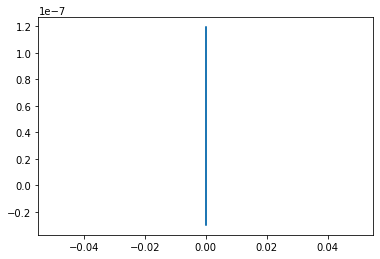

In [37]:
x,y = sm.symbols("x,y")

def expr_A():
    print('passed here')
    def expr_f_0(y):
        return sm.exp(-y/5)*sm.sin(y)
    def expr_f_1(y):
        return sm.exp(-(a+y)/5)*sm.sin(a**2+y)
    def expr_g_0(x):
        return sm.exp(-(a*x)/5)*sm.sin((a*x)**2)
    def expr_g_1(x):
        return sm.exp(-(a*x+1)/5)*sm.sin((a*x)**2+1)
    # print(expr_g_1(x))
    # print(expr_f_1(y))
    # first_part = (1-x)*expr_f_0(y)+x*expr_f_1(y)
    # print('first_part:\n',first_part)
    # second_part = (1-y)*(expr_g_0(x)-((1-x)*expr_g_0(0)+x*expr_g_0(1))+y*(expr_g_1(x)-((1-x)*expr_g_1(0)+x*expr_g_1(1))))
    # bottom = (expr_g_1(x)-((1-x)*expr_g_1(0)+x*expr_g_1(1)))
    # print('bottom:',bottom)
    return (1-x)*expr_f_0(y)+x*expr_f_1(y)+(1-y)*(expr_g_0(x)-((1-x)*expr_g_0(0)+x*expr_g_0(1)))+y*(expr_g_1(x)-((1-x)*expr_g_1(0)+x*expr_g_1(1)))

expr_A = expr_A()
print("expr_A:\n",expr_A)
expr_A = sm.lambdify([x, y], sm.Matrix([expr_A]), 'numpy')

def evaluate_A(X):
    A = tf.expand_dims(tf.squeeze(expr_A(X[:, 0], X[:, 1])), axis=-1)
    A = tf.cast(A, dtype=DTYPE)
    return A


a = 3
DTYPE = np.float32
@tf.function
def true_function(X):
    return tf.exp(-(a*X[:, 0]+X[:, 1])/5)*tf.sin(a**2*X[:, 0]**2+X[:, 1])

batch_size = 10
line = tf.cast(tf.reshape(np.linspace(0,1,num=batch_size,endpoint=True),(batch_size,1)),dtype=DTYPE)
boundary_L = tf.concat([tf.zeros((batch_size,1),dtype=DTYPE),line],axis=1)
boundary_R = tf.concat([tf.ones((batch_size,1),dtype=DTYPE),line],axis=1)
boundary_up = tf.concat([line,tf.ones((batch_size,1),dtype=DTYPE)],axis=1)
boundary_bot = tf.concat([line,tf.zeros((batch_size,1),dtype=DTYPE)],axis=1)
# true_function(boundary_L)-evaluate_A(boundary_L)
test_boundary = boundary_bot
print(true_function(test_boundary).shape)
print(evaluate_A(test_boundary).shape)
error = tf.expand_dims(true_function(test_boundary),-1)-evaluate_A(test_boundary)
print(error)
print(np.max(error))
plt.plot(test_boundary[:,1].numpy(),error)
plt.show()

In [24]:

x,y = sm.symbols("x,y")
dim = 2
X = tf.random.uniform((5,dim),0,1,dtype=np.float32)
pi = np.pi
DTYPE = np.float32

def expr_A():
    def expr_f_0(y):
        return 0

    def expr_f_1(y):
        return 0

    def expr_g_0(x):
        return 0

    def expr_g_1(x):
        return 2*sm.sin(pi*x)
    if True:
        return (1-x)*expr_f_0(y)+x*expr_f_1(y)+expr_g_0(x)-((1-x)*expr_g_0(0)+x*expr_g_0(1))+y*(expr_g_1(x)-((1-x)*expr_g_1(0)+x*expr_g_1(1)))
    else:
        return (1-x)*expr_f_0(y)+x*expr_f_1(y)+(1-y)*(expr_g_0(x)-((1-x)*expr_g_0(0)+x*expr_g_0(1)))+y*(expr_g_1(x)-((1-x)*expr_g_1(0)+x*expr_g_1(1)))


expr_A = expr_A()
dexpr_A_dx = sm.diff(expr_A, x, 1)
dexpr_A_dxx = sm.diff(dexpr_A_dx, x, 1)
dexpr_A_dy = sm.diff(expr_A, y, 1)
dexpr_A_dyy = sm.diff(dexpr_A_dy, y, 1)


# remark: You can forget a no lambdified expression => here we greatly avoid 'for' loops

expr_A = sm.lambdify([x, y], sm.Matrix([expr_A]), 'numpy')
dexpr_A_dx = sm.lambdify([x, y], sm.Matrix([dexpr_A_dx]), 'numpy')
dexpr_A_dxx = sm.lambdify([x, y], sm.Matrix([dexpr_A_dxx]), 'numpy')
dexpr_A_dy = sm.lambdify([x, y], sm.Matrix([dexpr_A_dy]), 'numpy')
dexpr_A_dyy = sm.lambdify([x, y], sm.Matrix([dexpr_A_dyy]), 'numpy')


def evaluate_A_and_diff(X):
    results = []
    A = tf.expand_dims(tf.squeeze(expr_A(X[:, 0], X[:, 1])), axis=-1)
    A = tf.cast(A, dtype=DTYPE)
    results.append(A)
    dA_dx = tf.expand_dims(tf.squeeze(dexpr_A_dx(X[:, 0], X[:, 1])), axis=-1)
    dA_dx = tf.cast(dA_dx, dtype=DTYPE)
    results.append(dA_dx)
    dA_dxx = tf.expand_dims(tf.squeeze(dexpr_A_dxx(X[:, 0], X[:, 1])), axis=-1)
    dA_dxx = tf.cast(dA_dxx, dtype=DTYPE)
    results.append(dA_dxx)
    dA_dy = tf.expand_dims(tf.squeeze(dexpr_A_dy(X[:, 0], X[:, 1])), axis=-1)
    dA_dy = tf.cast(dA_dy, dtype=DTYPE)
    results.append(dA_dy)
    print('dexpr_A_dyy(X[:, 0], X[:, 1]):\n',dexpr_A_dyy(X[:, 0], X[:, 1]).shape)
    dA_dyy = tf.expand_dims(tf.squeeze(dexpr_A_dyy(X[:, 0], X[:, 1])), axis=-1)
    dA_dyy = tf.cast(dA_dyy, dtype=DTYPE)
    results.append(dA_dyy)
    for i,dA_ in enumerate(results):
        if dA_.shape == (1,):
            results[i]=dA_[0]
    return results

batch_size = 3
line = tf.cast(tf.reshape(np.linspace(0,1,num=batch_size,endpoint=True),(batch_size,1)),dtype=DTYPE)
boundary_L = tf.concat([tf.zeros((batch_size,1),dtype=DTYPE),line],axis=1)
boundary_R = tf.concat([tf.ones((batch_size,1),dtype=DTYPE),line],axis=1)
boundary_up = tf.concat([line,tf.ones((batch_size,1),dtype=DTYPE)],axis=1)
boundary_bot = tf.concat([line,tf.zeros((batch_size,1),dtype=DTYPE)],axis=1)
# true_function(boundary_L)-evaluate_A(boundary_L)
test_boundary = boundary_bot
A, dA_dx, dA_dxx, dA_dy, dA_dyy = evaluate_A_and_diff(test_boundary)
print(dA_dyy+A)
# print(dA_dyy)


dexpr_A_dyy(X[:, 0], X[:, 1]):
 (1, 1)
tf.Tensor(
[[0.]
 [0.]
 [0.]], shape=(3, 1), dtype=float32)
